In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [2]:
warnings.filterwarnings('ignore')

In [3]:
TextFileReader = pd.read_csv('data.csv',encoding='ISO-8859-1',chunksize=500000, low_memory=False)  # the number of rows per chunk

dfList = []
for df in TextFileReader:
    dfList.append(df)

df = pd.concat(dfList,sort=False)

In [ ]:
#to protect client's privacy,all variables have been encripted,except target(Act_delay and date)

In [ ]:
#Remove Nulls
df = df[df['I'].notnull()]
df = df[df['m'].notnull()]
df = df[df['b'].notnull()]
df = df[df['z'].notnull()]

In [ ]:
#log transform skewed distributions
df['h'] = df['h'].apply(lambda x: np.log(x+1))
df['g'] = df['g'].apply(lambda x: np.log(x+1))
df['y'] = df['y'].apply(lambda x: np.log(x+1))
df['z'] = df['z'].apply(lambda x: np.log(x+1))
df['t'] = df['t'].apply(lambda x: np.log(x+1))

In [ ]:
#replace low frequency category as "others"
df_k = pd.DataFrame(df['k'].value_counts(normalize=True))*100
small_cat1= df_k[df_k['k']<1].index
df['k_new1'] = df['k'].replace(small_cat1,"others")

df_j= pd.DataFrame(df['j'].value_counts(normalize=True))*100
small_cat2 = df_j[df_j['j']<0.5].index
df['j_new1'] = df['j'].replace(small_cat2 , 'others')

df_b=pd.DataFrame(df['b'].value_counts(normalize=True)*100, columns=['CBU'])
small_cat3 = df_b[df_b['b']<1].index
df['b_new'] = df['b'].replace(small_cat3,'others')

df_n = pd.DataFrame(df['n'].value_counts(normalize=True))*100
small_cat4 = df_n[df_n['n']<5].index
df['n_new'] = df['n'].replace(small_cat4,'Others')

df['CreatedDate_new']= pd.to_datetime(df['CreatedDate'].astype(str), format='%Y-%m-%d')
df['created_month']=df['CreatedDate_new'].dt.month
df['created_quater']=df['CreatedDate_new'].dt.quarter

df_e=pd.DataFrame(df['e'].value_counts())
small_cat5 = df_e[df_e['e']<40000].index
df['e_new'] = df['e'].replace(small_cat5,'Others')

In [ ]:
#Target-mean encodeing of highly cardinal variables
def calc_smooth_mean(df11, df22, cat_name, target, weight):
    # Compute the global mean
    mean = df[target].mean()

    # Compute the number of values and the mean of each group
    agg = df.groupby(cat_name)[target].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']

    # Compute the "smoothed" means
    smooth = (counts * means + weight * mean) / (counts + weight)

    # Replace each value by the according smoothed mean
    if df22 is None:
        return df11[cat_name].map(smooth)
    else:
        return df11[cat_name].map(smooth),df21[cat_name].map(smooth.to_dict())

In [ ]:
WEIGHT = 0
df['m_enc'] = calc_smooth_mean(df11=df, df22=None, cat_name='m', target='Act_delay', weight=WEIGHT)
df['q_enc'] = calc_smooth_mean(df11=df, df22=None, cat_name='q', target='Act_delay', weight=WEIGHT)
df['a_enc'] = calc_smooth_mean(df11=df, df22=None, cat_name='a', target='Act_delay', weight=WEIGHT)
df['p_enc'] = calc_smooth_mean(df11=df, df22=None, cat_name='p', target='Act_delay', weight=WEIGHT)

In [5]:
df_num = df.select_dtypes(exclude=object)

In [2]:
df_num = pd.read_csv('df_num.csv')

In [3]:
corr_matrix = df_num.corr()

In [4]:
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

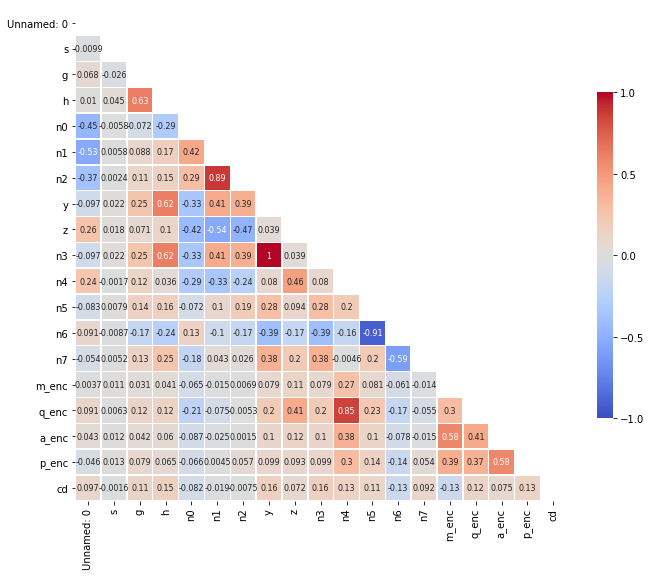

In [5]:
f, ax = plt.subplots(figsize=(11, 15)) 
heatmap = sb.heatmap(corr_matrix, 
                      mask = mask,
                      square = True,
                      linewidths = .5,
                      cmap = 'coolwarm',
                      cbar_kws = {'shrink': .4, 
                                'ticks' : [-1, -.5, 0, 0.5, 1]},
                      vmin = -1, 
                      vmax = 1,
                      annot = True,
                      annot_kws = {'size': 8})#add the column names as labels
ax.set_yticklabels(corr_matrix.columns, rotation = 0)
ax.set_xticklabels(corr_matrix.columns)
sb.set_style({'xtick.bottom': True},{'ytick.left': True})

In [ ]:
#Removed variables due to high correlation
#'n4'(corr with 'q_enc')
#'n5'(corr with 'n6')
#'n7'(corr with 'n6')

#'y'(corr with 'n3')
#'n2' (corr with n1)
# 'q_enc' (corr with 'n4')

In [ ]:
df.shape

(2187724, 87)

Model Fitting 

In [ ]:
X = df.drop(['n4','n5','n7','y','n2', 'q_enc',], axis=1)

In [ ]:
y = df['Act_delay']

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [ ]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= X_train.columns)
y_train1 = y_train.values.reshape(-1,1)
y_train_scaled = scaler.fit_transform(y_train1)

In [ ]:
X_test_scaled = pd.DataFrame(scaler.fit_transform(X_test), columns= X_test.columns)
y_test1 = y_test.values.reshape(-1,1)
y_test_scaled = scaler.fit_transform(y_test1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
model1 = RandomForestRegressor()
paremeters_rf = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
                 "max_features" : ["auto", "log2"]}
grid_rf = GridSearchCV(model1, paremeters_rf, verbose=1, scoring="r2")
grid_rf.fit(X_train_scaled,y_train_scaled)

print("Best RandomForestRegressor Model: " + str(grid_rf.best_estimator_))
print("Best Score: " + str(grid_rf.best_score_))

In [ ]:
model1 = grid_rf.best_estimator_
model1.fit(X_train_scaled,y_train_scaled)
rf_pred = model1.predict(X_test_scaled)
r2_rf = r2_score(y_test_scaled, rf_pred)
rmse_rf = np.sqrt(mean_squared_error(y_test_scaled, rf_pred))
print("R^2 Score: " + str(r2_rf))
print("RMSE Score: " + str(rmse_rf))

In [ ]:
yhat = model1.predict(X_test_scaled)
pred1 = np.round(scaler.inverse_transform(yhat),2)

prediction

In [ ]:
X_test['prediction']=pred1
X_test['Act_delay']= y_test

In [23]:
X_test[['prediction','Act_delay']]

,prediction,Act_delay
843380,-2.67,-2
765672,0.23,1
660881,-3.85,-2
1866414,-11.87,-10
1063718,-1.47,-2
1824963,15.82,15
1396951,5.93,8
458445,-5.57,-13
1750684,-11.07,-7
1888456,1.03,0


Variable Importance

In [24]:
#inbuilt variable importance
Var_imp = pd.DataFrame(model1.feature_importances_, index=X_train_scaled.columns, 
columns=['variable importance'])
Var_imp.sort_values('variable importance', ascending=False)

In [ ]:
#permuted variable importance
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model1, random_state=1).fit(X_test_scaled, y_test)
eli5.show_weights(perm, feature_names = X_test_scaled.columns.tolist())

In [28]:
from sklearn.externals import joblib 
joblib.dump(model1,'saved_model')

C:\Users\ERANDI DUNUMALAGE\AppData\Roaming\Python\Python37\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['saved_model']